In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random
from sklearn.metrics import f1_score
import time

device = torch.device("cpu")


CSV_DOSYASI = "C:/Users/samsu/Downloads/proje/archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/egitim_icin_hazir.csv"
ANA_KLASOR = r"C:/Users/samsu/Downloads/proje/archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
BATCH_SIZE = 16 
LEARNING_RATE = 0.001
EPOCHS = 15
RESIM_BOYUTU = 128


class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)


class SafCNN(nn.Module):
    def __init__(self, num_classes):
        super(SafCNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(128 * 16 * 16, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.classifier(out)
        return out


if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    print("Veriler Hazırlanıyor...")
    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")
    
    model = SafCNN(num_classes=len(dataset.sinif_isimleri)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("\nEĞİTİM BAŞLIYOR... (Her 50 adımda bir bilgi verecek)")
    print("-" * 60)

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        

        start_time = time.time()
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

            if (i+1) % 50 == 0:
                print(f"Epoch [{epoch+1}] | Adım [{i+1}/{len(train_loader)}] | Anlık Loss: {loss.item():.4f}")
        

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct / total
        elapsed_time = time.time() - start_time
        
        print(f"Epoch {epoch+1} Bitti ({elapsed_time:.1f} sn) | Train Acc: %{train_acc:.2f} | Loss: {avg_train_loss:.4f}")
        print("Doğrulama (Validation) yapılıyor...")
        
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        print(f"VAL ACC: %{val_acc:.2f}")
        print("-" * 60)

    torch.save(model.state_dict(), 'amd_model_final.pth')
    print("Model Kaydedildi.")

Veriler Hazırlanıyor...
Train: 63011 | Val: 15753

EĞİTİM BAŞLIYOR... (Her 50 adımda bir bilgi verecek)
------------------------------------------------------------
Epoch [1] | Adım [50/3939] | Anlık Loss: 3.5823
Epoch [1] | Adım [100/3939] | Anlık Loss: 3.0837
Epoch [1] | Adım [150/3939] | Anlık Loss: 2.9926
Epoch [1] | Adım [200/3939] | Anlık Loss: 2.5301
Epoch [1] | Adım [250/3939] | Anlık Loss: 2.2462
Epoch [1] | Adım [300/3939] | Anlık Loss: 2.1838
Epoch [1] | Adım [350/3939] | Anlık Loss: 1.7566
Epoch [1] | Adım [400/3939] | Anlık Loss: 1.8370
Epoch [1] | Adım [450/3939] | Anlık Loss: 2.2531
Epoch [1] | Adım [500/3939] | Anlık Loss: 1.5094
Epoch [1] | Adım [550/3939] | Anlık Loss: 2.4799
Epoch [1] | Adım [600/3939] | Anlık Loss: 1.5032
Epoch [1] | Adım [650/3939] | Anlık Loss: 1.7178
Epoch [1] | Adım [700/3939] | Anlık Loss: 1.3331
Epoch [1] | Adım [750/3939] | Anlık Loss: 1.8456
Epoch [1] | Adım [800/3939] | Anlık Loss: 1.5086
Epoch [1] | Adım [850/3939] | Anlık Loss: 1.5504
Epo

In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random
from sklearn.metrics import f1_score, accuracy_score, classification_report


CSV_DOSYASI = "C:/Users/samsu/Downloads/proje/archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/egitim_icin_hazir.csv"
ANA_KLASOR = r"C:/Users/samsu/Downloads/proje/archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
MODEL_PATH = "amd_model_final.pth" 
BATCH_SIZE = 16 
RESIM_BOYUTU = 128


device = torch.device("cpu")
print("Test işlemi için İŞLEMCİ (CPU) kullanılıyor.")


class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi: dosya_adi = dosya_adi.split('?')[0]
            
            yollar = [os.path.join(self.root_dir, sinif_ismi, dosya_adi),
                      os.path.join(self.root_dir, dosya_adi),
                      os.path.join(self.root_dir, sinif_ismi, dosya_adi[:-4] + ".jpg")]
            
            hedef_yol = None
            for yol in yollar:
                if os.path.exists(yol):
                    hedef_yol = yol
                    break
            
            if hedef_yol is None: raise FileNotFoundError()

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)


class SafCNN(nn.Module):
    def __init__(self, num_classes):
        super(SafCNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(128 * 16 * 16, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.classifier(out)
        return out


if __name__ == '__main__':
    print("Test Verileri Hazırlanıyor...")
    
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])


    dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    _, val_dataset = random_split(dataset, [train_size, val_size])
    

    test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Test Edilecek Görüntü Sayısı: {len(val_dataset)}")
    

    num_classes = len(dataset.sinif_isimleri)
    model = SafCNN(num_classes=num_classes).to(device)
    

    if os.path.exists(MODEL_PATH):
        print(f"Model yükleniyor: {MODEL_PATH}")

        model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
        model.eval() 
    else:
        print(f"HATA: '{MODEL_PATH}' bulunamadı! Dosya adını kontrol et.")
        exit()

    print("\nTEST BAŞLIYOR... (Lütfen bekleyin)")
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
            
            if (i+1) % 50 == 0:
                print(f"   İşlenen paket: {i+1}...")


    acc = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    print("\n" + "="*50)
    print("MODEL PERFORMANS RAPORU")
    print("="*50)
    print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
    print(f"Genel F1 Skoru (Weighted): {f1_weighted:.4f}")
    print(f"Genel F1 Skoru (Macro)   : {f1_macro:.4f}")
    print("-" * 50)
    
    print("\nHASTALIK BAZLI DETAYLI RAPOR:")

    print(classification_report(all_labels, all_preds, target_names=dataset.sinif_isimleri))

Test işlemi için İŞLEMCİ (CPU) kullanılıyor.
Test Verileri Hazırlanıyor...
Test Edilecek Görüntü Sayısı: 15753
Model yükleniyor: amd_model_final.pth

TEST BAŞLIYOR... (Lütfen bekleyin)
   İşlenen paket: 50...
   İşlenen paket: 100...
   İşlenen paket: 150...
   İşlenen paket: 200...
   İşlenen paket: 250...
   İşlenen paket: 300...
   İşlenen paket: 350...
   İşlenen paket: 400...
   İşlenen paket: 450...
   İşlenen paket: 500...
   İşlenen paket: 550...
   İşlenen paket: 600...
   İşlenen paket: 650...
   İşlenen paket: 700...
   İşlenen paket: 750...
   İşlenen paket: 800...
   İşlenen paket: 850...
   İşlenen paket: 900...
   İşlenen paket: 950...

MODEL PERFORMANS RAPORU
Genel Doğruluk (Accuracy): %97.94
Genel F1 Skoru (Weighted): 0.9793
Genel F1 Skoru (Macro)   : 0.9773
--------------------------------------------------

HASTALIK BAZLI DETAYLI RAPOR:
                                            precision    recall  f1-score   support

                           Apple Scab Leaf     

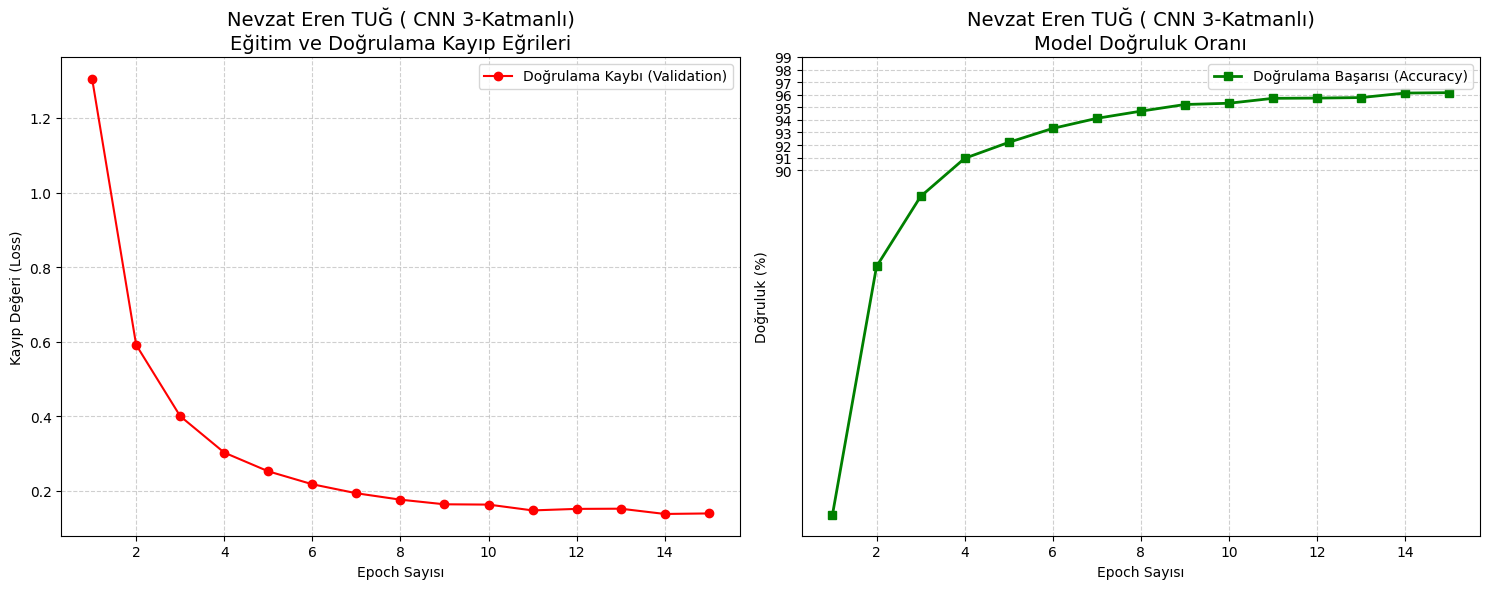

In [5]:
import matplotlib.pyplot as plt

USER_INFO = "Nevzat Eren TUĞ ( CNN 3-Katmanlı)"

epochs = list(range(1, 16))
val_losses = [1.3051,0.5915,0.4004,0.3028,0.2526,0.2179,0.1938,0.1766,0.1642,0.1634,0.1478, 0.1519, 0.1524, 0.1383, 0.1397]
accuracies =  [62.63, 82.35, 87.91, 90.94, 92.21, 93.32, 94.12, 94.69, 95.22, 95.32, 95.71, 95.73, 95.77, 96.13, 96.16]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, 'r-o', label='Doğrulama Kaybı (Validation)')

plt.title(f'{USER_INFO}\nEğitim ve Doğrulama Kayıp Eğrileri', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Kayıp Değeri (Loss)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g-s', linewidth=2, label='Doğrulama Başarısı (Accuracy)')

plt.title(f'{USER_INFO}\nModel Doğruluk Oranı', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')
plt.yticks(range(90, 100, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()